# Notebook for Testing Pipelines

In [1]:
# Imports 
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yaml
import os, sys
from typing import Dict
import numpy as np


# Local Imports
module_path = os.path.abspath(os.path.join('code'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from Signal_Transfomers import (ConvertIndexToTimestamp, ExtractSignals,
                                BandpassFilter, BandstopFilter, ReplaceOutliers,
                                CenterData)

from Pre_Processing_Transformers import (SlidingWindow, NormalizeData, DeleteFaultyEpochs,
                                            ReplaceNaNs)


from Feature_Extraction_Transformer import (Frequency_Features)

from Measuring_Functions import (getChannelUsageInEpochSeries)

from plotFunctions import (plotInteractiveEpochs, plotFeatureEpochs)
from consts import *

### Define local functions

In [125]:
def loadConfigFile(configFilePath : str) -> Dict:
    with open(configFilePath, 'r') as stream:
        try:
            yamlConfig = yaml.safe_load(stream)
            return yamlConfig
        except yaml.YAMLError as exc:
            print(exc)
            return None

def readFileCSV(filePath : str) -> pd.DataFrame:
    df = pd.read_csv(filePath)
    return df


def filter_signal(df : pd.DataFrame, config : Dict, starttime=None) -> pd.DataFrame:
    ''' Filter the signal with bandpass, bandstopp and repace outliers '''

    # signal processing pipeline - the first pipeline - e.g. extract the signal from the raw .csv and filter it
    signal_processing_pipeline = Pipeline([
        ('Convert Index to Timestamp', ConvertIndexToTimestamp(device=config['deviceName'], starttime=starttime)),
        ('Extract signals', ExtractSignals(device=config['deviceName'])),
        ('Bandpass Filter', BandpassFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandpass'], highcutfreq=config['highcutFreq_bandpass'], samplingRate=config['samplingRate'])),
        ('Bandstop Filter', BandstopFilter(device=config['deviceName'], lowcufreq=config['lowcutFreq_bandstopp'], highcutfreq=config['highcutFreq_bandstopp'], samplingRate=config['samplingRate'])),
        ('Replace Outliers', ReplaceOutliers(device=config['deviceName'], lowerThreshold=config['lowerThreshold'], upperThreshold=config['upperThreshold']))
    ])
    df = signal_processing_pipeline.fit_transform(df)
    return df

def pre_process_signal(df : pd.DataFrame, config : Dict) -> pd.Series:
    ''' Pre-process the signal by creating epochs, delete faulty epochs and normalize it
    
    Returns a series of dataframes
    '''
    # pre-process the pipeline for machine learning
    pre_processing_pipeline = Pipeline([
        ('Create Epochs', SlidingWindow(samplingRate=config['samplingRate'], windowSizeInSeconds=config['epochWindowSize'], overlapInSeconds=config['overlap'])),
        ('Delete Faulty Epochs', DeleteFaultyEpochs(maxFaultyRate=config['maxFaultyRate'])), # returns a numpy series with dataframes
        ('Replace NaNs with Zero', ReplaceNaNs()),
        ('Normalize Data', NormalizeData())
    ])

    epochSeries = pre_processing_pipeline.fit_transform(df)
    return epochSeries

def feature_extraction(epochSeries : pd.Series, config : Dict) -> pd.Series:
    ''' Extract features from the generated epoch series 
    
    Do the whole feature extraction in a pipeline
    '''

    feature_extraction_pipeline = Pipeline([
        ("Frequency Band feature extraction", Frequency_Features(samplingRate=config['samplingRate'], frequencyBands=config['frequencyBands'],
                                                                numberOfChannels=config['numberOfChannels'], epochSizeCalculation=config['epochSizeCalculation']))
    ])

    epochSeries = feature_extraction_pipeline.fit_transform(epochSeries)

    return epochSeries

def generateFeatureDf(csvFilePath, starttime, yamlConfig, label : str, generateData : bool = True, mainDir : str = None) -> pd.DataFrame:
    ''' Generates datframes of given csv filepaths'''
    
    if not generateData:
        if mainDir is None:
            print("Enter a main directory where the pickle files can be found!")
            return None
        print ("Reading pickles files for {} data...".format(label))
        frequencyFeatureDf = pd.read_pickle(os.path.join(mainDir,'generatedData','frequencyFeaturesDf_{}.pkl'.format(label)))
        epochSeries = pd.read_pickle(os.path.join(mainDir,'generatedData','epochSeries_{}.pkl'.format(label)))
        return (epochSeries, frequencyFeatureDf)
        
    # ### GENERATE DATA ###
    print ("Generating {} driving feature df...".format(label))
    # load dataset
    df = readFileCSV(csvFilePath)  
    
    # Filter the signal
    df = filter_signal(df=df, config=yamlConfig, starttime=starttime)

    # Pre-process the signal
    epochSeries = pre_process_signal(df=df, config=yamlConfig)
    # Save epochSeries
    print("Saving epoch series...")
    epochSeries.to_pickle(os.path.join(mainDir,'generatedData','epochSeries_{}.pkl'.format(label)))


    # Extract Frequency Features
    frequencyFeatureDf = feature_extraction(epochSeries=epochSeries, config=yamlConfig)
    # Save frequency features dataframe
    print("Saving frequency feature dataframe...")
    frequencyFeatureDf.to_pickle(os.path.join(mainDir,'generatedData','frequencyFeaturesDf_{}.pkl'.format(label)))
    
    return (epochSeries, frequencyFeatureDf)

## Main

In [127]:
GENERATE_DATA = False
# load config
MAIN_DIR = "D:/Masterthesis/thesis_eeg/"

TARGET_AWAKE = "awake"
TARGET_NON_AWAKE = "non_awake"
TARGET_UNLABELED = "unlabeled"

configFilePath = "D:/Masterthesis/thesis_eeg/config/openBci.yaml"
yamlConfig = loadConfigFile(configFilePath)
#print(yamlConfig)

subjectDict = {"subjectId" : 1,
               "awakeCsvPath" : "D:/OneDrive - bwedu/Masterthesis/Experiments+Data/Fahren+AimLab/2020_03_05_Propand_1/openBci_record-[2020.03.05-12.27.35]_raw_awake_aimlab.csv",
               "unlabeledCsvPath" : "D:/OneDrive - bwedu/Masterthesis/Experiments+Data/Fahren+AimLab/2020_03_05_Propand_1/openBci_record-[2020.03.05-12.34.34]_raw_driving_unlabled.csv"}


# ---- AWAKE DATA -----
epochSeries_awake, frequencyFeatureDf_awake = generateFeatureDf(csvFilePath= subjectDict['awakeCsvPath'],
                                                    starttime = pd.Timestamp(datetime.strptime('[2020.03.05-12.27.27]', "[%Y.%m.%d-%H.%M.%S]")),
                                                    yamlConfig = yamlConfig,
                                                    label = TARGET_AWAKE,
                                                    generateData = GENERATE_DATA,
                                                    mainDir = MAIN_DIR)

# ---- UNLABELED DATA -----
epochSeries_unlabeled, frequencyFeatureDf_unlabeled = generateFeatureDf(csvFilePath= subjectDict['unlabeledCsvPath'],
                                                            starttime = pd.Timestamp(datetime.strptime('[2020.03.05-12.34.34]', "[%Y.%m.%d-%H.%M.%S]")),
                                                            yamlConfig = yamlConfig,
                                                            label = TARGET_UNLABELED,
                                                            generateData = GENERATE_DATA,
                                                            mainDir = MAIN_DIR)

# ---- Create NON-WAKE DATA ----
frequencyFeatureDf_non_awake = frequencyFeatureDf_unlabeled[110:160] # 50 epochs = 50 x 5 seconds = 250 seconds
frequencyFeatureDf_non_awake.reset_index(drop=True, inplace=True)




print("Frequency Feature Df has {} Epochs and {} Features.".format(frequencyFeatureDf_unlabeled.shape[0],
                                                                    frequencyFeatureDf_unlabeled.shape[1],
                                                                    yamlConfig['epochSizeCalculation']))




Reading pickles files for awake data...
Reading pickles files for unlabeled data...
Frequency Feature Df has 182 Epochs and 570 Features.


In [36]:

# Important! Add the '_' at the end! If not then channel_1 would find channel_10, channel_11, etc. !!!
channelsToUse = ['channel_1_', 'channel_2_']

filterDfByColumns(frequencyFeatureDf_awake, channelsToUse)

,channel_1_Delta_mean_bandpower_list,channel_1_Delta_mean_bandpower_lower_envelope_list,channel_1_Delta_mean_bandpower_upper_envelope_list,channel_1_Delta_std_dev_bandpower_list,channel_1_Delta_std_dev_bandpower_lower_envelope_list,channel_1_Delta_std_dev_bandpower_upper_envelope_list,channel_1_Theta_mean_bandpower_list,channel_1_Theta_mean_bandpower_lower_envelope_list,channel_1_Theta_mean_bandpower_upper_envelope_list,channel_1_Theta_std_dev_bandpower_list,...,channel_2_Beta_mean_bandpower_upper_envelope_list,channel_2_Beta_std_dev_bandpower_list,channel_2_Beta_std_dev_bandpower_lower_envelope_list,channel_2_Beta_std_dev_bandpower_upper_envelope_list,channel_2_Gamma_mean_bandpower_list,channel_2_Gamma_mean_bandpower_lower_envelope_list,channel_2_Gamma_mean_bandpower_upper_envelope_list,channel_2_Gamma_std_dev_bandpower_list,channel_2_Gamma_std_dev_bandpower_lower_envelope_list,channel_2_Gamma_std_dev_bandpower_upper_envelope_list
0,0.873650,0.798450,0.901276,0.086451,0.101559,0.041334,0.111363,0.068308,0.182582,0.082318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.822498,0.730348,0.899716,0.089718,0.034650,0.012459,0.093181,0.069761,0.104602,0.054271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.805817,0.778215,0.862313,0.073495,0.078653,0.006877,0.095938,0.051821,0.152790,0.066042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.651047,0.872558,NaN,0.024734,0.006412,NaN,0.098810,0.242554,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.819751,0.751335,0.903386,0.075179,0.059460,0.035030,0.147247,0.075551,0.204909,0.064229,...,NaN,0.007261,NaN,NaN,0.002860,NaN,NaN,0.001966,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.547954,0.355578,0.696178,0.224770,0.059982,0.120646,0.107236,0.042416,0.213840,0.083823,...,NaN,0.099771,NaN,NaN,0.100827,NaN,NaN,0.068780,NaN,NaN
67,0.672051,0.533203,0.849231,0.156086,0.068766,0.043527,0.140901,0.084032,0.194691,0.046484,...,NaN,0.094985,NaN,NaN,0.047946,NaN,NaN,0.027095,NaN,NaN
68,NaN,0.364181,0.809878,NaN,0.033259,0.024141,NaN,0.095327,0.163106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,0.609410,0.892335,NaN,0.098310,0.015698,NaN,0.034293,0.139054,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


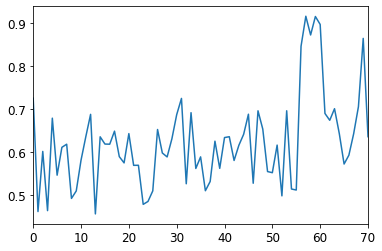

In [139]:
frequencyFeatureDf_awake['channel_18_Delta_mean_bandpower_list'].plot()

#epochSeries_awake[0].plot()

In [122]:
from typing import List

target_dict = {"awake" : 1, "non-awake" : 0, "unlabeled" : 2}

def filterDfByColumns(df : pd.DataFrame, columnsToKeep : List):
    if df is None:
        return df
    
    if columnsToKeep is None:
        return df
    
    requiredChannelList = []
    for dfColumn in df.columns:
        for requiredChannel in columnsToKeep:
            if requiredChannel in dfColumn:
                requiredChannelList.append(dfColumn)
        
    return df.filter(requiredChannelList)


def faultyFeaturesNames(df : pd.DataFrame, maxPercentageMissing = 0.0):
    ''' Measure the most stable feature, by counting the NaN Values
    Return a list of column names where the maximum percentage is higher then the given parameter
    This list is a list of columns which are not acceptable
    '''
    if df is None:
        return df
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    
    missing_value_df.sort_values('percent_missing', inplace=True)
    
    missing_value_df = missing_value_df[missing_value_df['percent_missing'] > maxPercentageMissing]
    return missing_value_df['column_name']

def countRecordsOfDf(df : pd.DataFrame) -> int:
    if df is None or df.empty:
        return 0
    else:
        return len(df)


def createDataAndTargetArray(awakeDf, non_awakeDf, unlabeledDf, channelsToUse = None, splitChannels = False, maxPercentageNanValues = 0.0):
    '''  This functions creates a data and a target array which can be fed into classifiers
    
    So far NaN values are getting replaced by 0 in this process!
    
    @param awakeDf: A dataframe which only contains awake data/features
    @param non_awakeDf: A dataframe which only contains non awake data/features
    @param unlabeledDf: A dataframe which only contains unlabeled data/features
    @param channelsToUse: A list of which channels should be used | If none then use all channels
    @param splitChannels: If True then seperate the data and target by the channels we want to use | If false, it returns a list with one data array and one target array
    @param maxPercentageNanValues: Defines how many NaN Values are allowed to be NaN (in percentage!)
    
    @return ([dataArray], [targetArray])
    '''
    targetArray = []
    dataDf = pd.DataFrame()
    
    print("Creating Data and Target Array...")
    if channelsToUse is None:
        print("Using all channels...")
    else:
        usedChannelString = "Using the channels: "
        for channel in channelsToUse: usedChannelString += "{}, ".format(channel)
        print(usedChannelString)
            
    # Filter all dataframes - If the DF or channel is None, nothing will happen
    awakeDf = filterDfByColumns(awakeDf, channelsToUse)
    non_awakeDf = filterDfByColumns(non_awakeDf, channelsToUse)
    unlabeledDf = filterDfByColumns(unlabeledDf, channelsToUse)
    
    print ("Using Features where the NaN percentage is equal or lower than: {}".format(maxPercentageNanValues))
    
    
    if awakeDf is not None:
        
        # Filter the features
        awakeDf = awakeDf.drop(faultyFeaturesNames(awakeDf, maxPercentageMissing=maxPercentageNanValues), axis='columns')
        
        if not awakeDf.empty: # it is possible that the Df is now empty...
            # TODO - Checken ob gut oder schlecht?!?!?
            awakeDf = awakeDf.fillna(0)

            startCounter = 0
            if dataDf.empty:
                # Do this because then it will copy also all columns, then we can append stuff
                dataDf = awakeDf.loc[:1]

                # append to awake into the target array
                targetArray.append(target_dict['awake'])
                targetArray.append(target_dict['awake'])
                startCounter = 2

            # We have to start at 2 if we added 0:1 already
            for i in range(startCounter, len(awakeDf)):
                dataDf = dataDf.append(awakeDf.loc[i], ignore_index=True)
                targetArray.append(target_dict['awake'])

            
    if non_awakeDf is not None:
        
        # Filter the features
        non_awakeDf = non_awakeDf.drop(faultyFeaturesNames(non_awakeDf, maxPercentageMissing=maxPercentageNanValues), axis='columns')
        if not non_awakeDf.empty: # it is possible that the Df is now empty...
        
            # TODO - Checken ob gut oder schlecht?!?!?
            non_awakeDf = non_awakeDf.fillna(0)
            
            startCounter = 0
            if dataDf.empty:
                # Do this because then it will copy also all columns, then we can append stuff
                dataDf = non_awakeDf.loc[:1]

                # append to awake into the target array
                targetArray.append(target_dict['non-awake'])
                targetArray.append(target_dict['non-awake'])
                startCounter = 2

            # We have to start at 2 if we added 0:1 already
            for i in range(startCounter, len(non_awakeDf)):
                dataDf = dataDf.append(non_awakeDf.loc[i], ignore_index=True)
                targetArray.append(target_dict['non-awake'])
            
            
    if unlabeledDf is not None:
        
        # Filter the features
        unlabeledDf = unlabeledDf.drop(faultyFeaturesNames(unlabeledDf, maxPercentageMissing=maxPercentageNanValues), axis='columns')
        
        if not unlabeledDf.empty: # it is possible that the Df is now empty...
            # TODO - Checken ob gut oder schlecht?!?!?
            unlabeledDf = unlabeledDf.fillna(0)

            startCounter = 0
            if dataDf.empty:
                # Do this because then it will copy also all columns, then we can append stuff
                dataDf = unlabeledDf.loc[:1]

                # append to awake into the target array
                targetArray.append(target_dict['unlabeled'])
                targetArray.append(target_dict['unlabeled'])
                startCounter = 2

            # We have to start at 2 if we added 0:1 already
            for i in range(startCounter, len(unlabeledDf)):
                dataDf = dataDf.append(unlabeledDf.loc[i], ignore_index=True)
                targetArray.append(target_dict['unlabeled'])

    # Information about the Arrays
    awakeRecords = countRecordsOfDf(awakeDf)
    non_awakeRecords = countRecordsOfDf(non_awakeDf)
    unlabeledRecords = countRecordsOfDf(unlabeledDf)
    
    print("""The Data/Target Array contains:
    - {awake} awake data records
    - {non_awake} non-awake data records
    - {unlabeled} unlabeled data records""".format(awake = awakeRecords,
                                                   non_awake = non_awakeRecords,
                                                   unlabeled = unlabeledRecords))

    return (dataDf.to_numpy(), np.array(targetArray))


channelsToUse = ['channel_1_']

dataArray, targetArray = createDataAndTargetArray(awakeDf = frequencyFeatureDf_awake,
                                                 non_awakeDf = frequencyFeatureDf_non_awake,
                                                 unlabeledDf = None,
                                                 channelsToUse = channelsToUse)



Creating Data and Target Array...
Using the channels: channel_1_, 
Using Features where the NaN percentage is equal or lower than: 0.0
The Data/Target Array contains:
    - 71 awake data records
    - 0 non-awake data records
    - 0 unlabeled data records


TypeError: 'tuple' object is not callable

In [116]:
testDf = filterDfByColumns(frequencyFeatureDf_non_awake, channelsToUse)
testDf = testDf.drop(faultyFeaturesNames(testDf, maxPercentageMissing=0.0), axis='columns')
len(testDf)

50

TypeError: object of type 'NoneType' has no len()

,channel_1_Delta_mean_bandpower_lower_envelope_list,channel_1_Delta_mean_bandpower_upper_envelope_list,channel_1_Delta_std_dev_bandpower_lower_envelope_list,channel_1_Delta_std_dev_bandpower_upper_envelope_list,channel_1_Theta_mean_bandpower_lower_envelope_list,channel_1_Theta_mean_bandpower_upper_envelope_list,channel_1_Theta_std_dev_bandpower_lower_envelope_list,channel_1_Theta_std_dev_bandpower_upper_envelope_list,channel_1_Alpha_mean_bandpower_lower_envelope_list,channel_1_Alpha_mean_bandpower_upper_envelope_list,...,channel_19_Beta_mean_bandpower_upper_envelope_list,channel_19_Beta_std_dev_bandpower_list,channel_19_Beta_std_dev_bandpower_lower_envelope_list,channel_19_Beta_std_dev_bandpower_upper_envelope_list,channel_19_Gamma_mean_bandpower_list,channel_19_Gamma_mean_bandpower_lower_envelope_list,channel_19_Gamma_mean_bandpower_upper_envelope_list,channel_19_Gamma_std_dev_bandpower_list,channel_19_Gamma_std_dev_bandpower_lower_envelope_list,channel_19_Gamma_std_dev_bandpower_upper_envelope_list
0,0.798450,0.901276,0.101559,0.041334,0.068308,0.182582,0.029744,0.095401,0.008215,0.013564,...,0.099235,0.006486,0.015619,0.070083,0.001483,0.006074,0.040994,0.002272,0.007036,0.027156
1,0.730348,0.899716,0.034650,0.012459,0.069761,0.104602,0.018073,0.055905,0.010896,0.050872,...,0.203654,0.076291,0.022662,0.006378,0.030215,0.037357,0.064141,0.021474,0.008278,0.006650
2,0.778215,0.862313,0.078653,0.006877,0.051821,0.152790,0.019833,0.073168,0.023440,0.074803,...,0.140409,0.030817,0.018173,0.035183,0.037949,0.031741,0.043311,0.010609,0.007571,0.003714
3,0.651047,0.872558,0.024734,0.006412,0.098810,0.242554,0.008288,0.014456,0.013249,0.050897,...,0.106013,0.019535,0.015945,0.020528,0.035353,0.026697,0.046427,0.007130,0.002086,0.004580
4,0.751335,0.903386,0.059460,0.035030,0.075551,0.204909,0.030226,0.005174,0.015445,0.028106,...,0.105478,0.036773,0.002518,0.031624,0.033240,0.020922,0.037694,0.016230,0.004230,0.010049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.355578,0.696178,0.059982,0.120646,0.042416,0.213840,0.005931,0.083734,0.021935,0.052325,...,0.081230,0.016163,0.011493,0.006610,0.024701,0.018003,0.039940,0.008710,0.002801,0.001800
67,0.533203,0.849231,0.068766,0.043527,0.084032,0.194691,0.016692,0.035978,0.020007,0.067214,...,0.073559,0.017764,0.006325,0.007355,0.024770,0.019699,0.026871,0.006766,0.002104,0.004431
68,0.364181,0.809878,0.033259,0.024141,0.095327,0.163106,0.010380,0.002316,0.035822,0.172109,...,0.072191,0.031725,0.027770,0.006844,0.017533,0.013415,0.020862,0.009683,0.009365,0.010903
69,0.609410,0.892335,0.098310,0.015698,0.034293,0.139054,0.025414,0.014690,0.008922,0.066175,...,0.090037,0.009621,0.028428,0.008487,0.003340,0.002873,0.011824,0.004091,0.005806,0.011632


In [125]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataArray, targetArray, test_size=0.3,random_state=109, shuffle=False) # 70% training and 30% test

In [148]:
#Import svm model
from sklearn import svm


#Create a svm Classifier
clf = svm.SVC(kernel="poly", degree=3, coef0=1, C=5, gamma="auto")


#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [149]:
test = frequencyFeatureDf_unlabeled.fillna(0)
test = test.to_numpy()
clf.predict(test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [150]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.0
Precision: 0.0
Recall: 0.0


C:\Users\reiss\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [151]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.82758621, 0.85714286, 0.85185185])

In [153]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
y_train_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [154]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[ 0, 13],
       [ 0, 71]], dtype=int64)

In [5]:
#Import scikit-learn dataset library
from sklearn import datasets

#Load dataset
cancer = datasets.load_breast_cancer()

In [18]:
cancer.data.shape

(569, 30)

In [23]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3,random_state=109) # 70% training and 30% test